#  Image Caption Generation


<pre> This project is image caption generation done using Flickr8k dataset. The model developed is a Encoder-Decoder Model with pretrained ResNet50 and BI-LSTM. 
Steps taken,
1) Loading Caption and Images
2) Preprocessing Dataset
3) Feature Extraction
4) Caption Padding and Vectorization
5) Model Developing
6) Prediction on test data
7) Evaluation</pre>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tarfile
import sys, os, time, warnings
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
from IPython.core.display import display, HTML
from keras import models
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image
from keras.layers import LSTM, Embedding,BatchNormalization, Dropout, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.regularizers import l2
from keras import layers
from keras.layers.advanced_activations import LeakyReLU, PReLU

In [0]:
list_flickr_img = "/content/drive/My Drive/Colab Notebooks/Untitled folder/img_dataset/"

img_dir = os.listdir(list_flickr_img)

list_flickr_caption = "/content/drive/My Drive/Colab Notebooks/Untitled folder/Flickr8k.token.txt"
train_file="/content/drive/My Drive/Colab Notebooks/Untitled folder/train_img.txt"
test_file="/content/drive/My Drive/Colab Notebooks/Untitled folder/test_img.txt"
val_file="/content/drive/My Drive/Colab Notebooks/Untitled folder/val_img.txt"


**Dataset Uploading**

In [0]:
print("Image:",len(img_dir))
captions = open(list_flickr_caption, 'r').read().split("\n")
print("Captions:",len(captions))
cap_train = open(train_file, 'r').read().split("\n")
print("Train:",len(cap_train))
cap_test = open(test_file, 'r').read().split("\n")
print("Test:",len(cap_test))
cap_val = open(val_file, 'r').read().split("\n")
print("Val:",len(cap_val))


Image: 8092
Captions: 40461
Train: 6001
Test: 1001
Val: 1001


Read the Flickr caption

In [0]:
desc_data = []
for read_line in captions:
    caption_col_data = read_line.split('\t')
    if len(caption_col_data) <= 1:
        break
    w = caption_col_data[0].split("#")
    desc_data.append(w + [caption_col_data[1].lower()])

dataf_text = pd.DataFrame(desc_data,columns=["img_name","index","img_caption"])
unique_img_names = np.unique(dataf_text.img_name.values)

In [0]:
dataf_text

,img_name,index,img_caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


## Visualization of Image and Captions

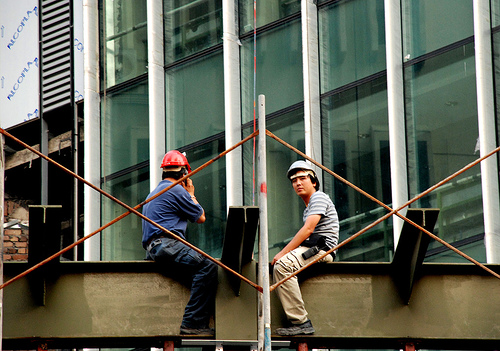

Two constructions workers sit on a beam taking a break .
Two construction workers are sitting up on the side of a building .
Two construction workers sitting on an I-beam .
Two construction workers take a seat on a steel beam .
Two men take a break from construction .


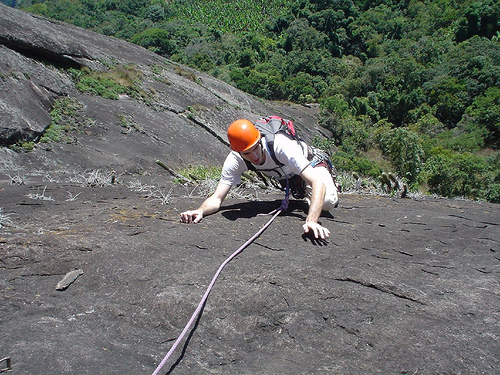

A climber in an orange helmet is ascending attached to a rope whilst climbing a rock face .
A gentleman is rock climbing .
A man rock-climbing
A rock climber ascends .
Downward view of a man with an orange helmet climbing a rock .


In [0]:
cap_token = {}
cap_length=len(captions)-1
ix=0
while ix < cap_length:
    tk = captions[ix].split("#")
    if tk[0] in cap_token:
        cap_token[tk[0]].append(tk[1][2:])
    else:
        cap_token[tk[0]] = [tk[1][2:]]
    ix=ix+1

temp = captions[200].split("#")
temp1= captions[2000].split("#")
from IPython.display import Image, display

# Passing Captions as values from dictionary and taking image filename as key to match with the image dataset.
z = Image(filename=list_flickr_img+temp[0])
display(z)
for ix in range(len(cap_token[temp[0]])):
    print(cap_token[temp[0]][ix])


y= Image(filename=list_flickr_img+temp1[0])
display(y)
for ix in range(len(cap_token[temp1[0]])):
    print(cap_token[temp1[0]][ix])

In [0]:
dataf_text['img_caption']

0        a child in a pink dress is climbing up a set o...
1                    a girl going into a wooden building .
2         a little girl climbing into a wooden playhouse .
3        a little girl climbing the stairs to her playh...
4        a little girl in a pink dress going into a woo...
                               ...                        
40455             a man in a pink shirt climbs a rock face
40456             a man is rock climbing high in the air .
40457    a person in a red shirt climbing up a rock fac...
40458                      a rock climber in a red shirt .
40459    a rock climber practices on a rock climbing wa...
Name: img_caption, Length: 40460, dtype: object

In [0]:
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

##  Unique Caption Extraction and Cleaning Caption
Here in the captions dataset each unique image has 5 captions. So we are extracting the captions and cleaning the descriptions word by word. 

Steps for cleaning captions:

1. Cleaning Puncuations
2. Cleaning Numeric values
3. Cleaning Single characters

After above steps we have stored the data into a pickle file.So that we can do not have to clean and run the captions everytime







In [0]:
def vocab_word(dataf_txt):
    vocabulary_words = []
    for text in range(len(dataf_text)):
        temp = dataf_text.iloc[text, 2]
        vocabulary_words.extend(temp.split())
    counter_words = Counter(vocabulary_words)
    counter_key = list(counter_words.keys())
    counter_value = list(counter_words.values())
    df_repeating_words = pd.DataFrame({"word":counter_key, "count":counter_value})
    df_repeating_words = df_repeating_words.sort_values("count", ascending=False)
    print(df_repeating_words)
    print("Total Count of Caption words:",len(vocabulary_words))
    return df_repeating_words

vocabword = vocab_word(dataf_text)
vocabword = vocabword.reset_index()[["word","count"]]

           word  count
0             a  62989
14            .  36581
2            in  18975
22          the  18419
37           on  10744
...         ...    ...
5730  backflips      1
5731     bikina      1
5732     saroog      1
5733    sarongs      1
8917   patterns      1

[8918 rows x 2 columns]
Total Count of Caption words: 476706


## Word Count Analysis
Used plot analysis for counting the word occurances.

Text(0.5, 1.0, 'count vs words')

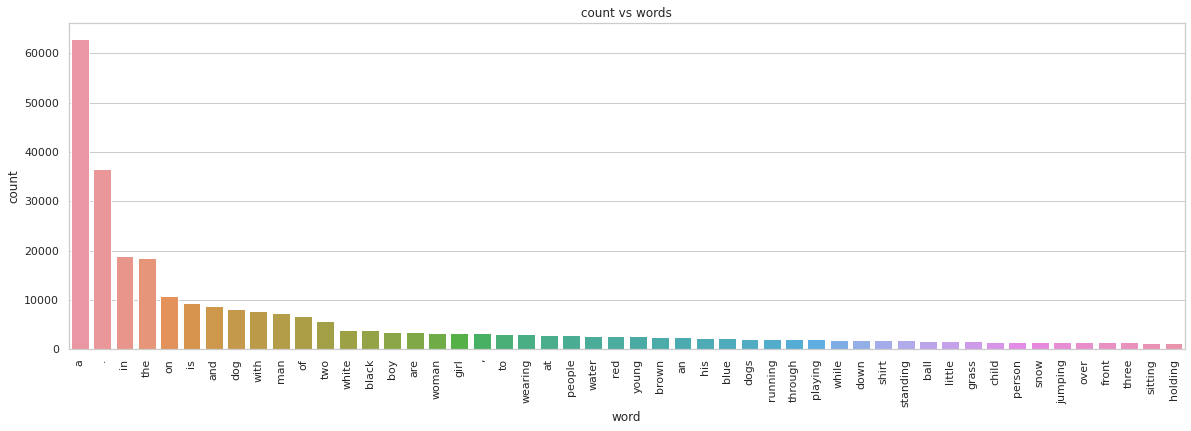

In [0]:
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x='word',y='count',data=vocabword[:50])
plt.xticks(rotation='vertical')
plt.title('count vs words')


In [0]:
data = dataf_text.copy()


In [0]:
data

,img_name,index,img_caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,a man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,a rock climber in a red shirt .


In [0]:
#cleaning caption texts, by removing the puncuations, single character amd numerics.
import string
def clean_caption(text):
    
    rm_punctuation_txt = text.translate(string.punctuation)
    rm_numeric_txt = ""
    for line in rm_punctuation_txt.split():
        is_alpha = line.isalpha()
        if is_alpha:
            rm_numeric_txt += " " + line

    rm_single_character = ""
    for line in rm_numeric_txt.split():
        if len(line) > 1:
            rm_single_character += " " + line
    return rm_single_character

pickle_clean_caption = {}

for position, caption in enumerate(data.img_caption.values):
    newcaption = clean_caption(caption)
    data["img_caption"].iloc[position] = newcaption

## Using Resnet50 for feature extraction
Here the features are extracted and stored in a pickle file.
Images of the train dataset are used for feature extraction. 
Steps:
Preprocessing the images using resnet50 weights. 
Expanding the image dimentions into 2048 for the resenet50.

In [0]:
# Model ResNet50 is the pretrained model. 
resnet_m = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
resnet_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
def load_img(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def processing_images(img_file_path):
    imd = image.load_img(img_file_path, target_size=(224,224,3))
    imd = image.img_to_array(imd)
    imd = np.expand_dims(imd, axis=0)
    return imd

In [0]:
train_data_tr = {}
ctr=0
for ix in cap_train:
    #print(ix)
    if ix == "":
        continue
    if ctr >= 6000:
        break
    ctr+=1
    if ctr%1000==0:
       print(ctr)
    img = processing_images(ix)
    pred = resnet_m.predict(img).reshape(2048)
    train_data_tr[ix] = pred

In [0]:
# opening new_img_values.p file and dumping it's content
with open( "/content/drive/My Drive/Colab Notebooks/Untitled folder/new_img_values.p", "wb" ) as pickle_f:
    pickle.dump(train_data_tr, pickle_f) 

## Loading image and its corresponding caption into a dataframe and then storing values

In [0]:
import pickle
from pickle import load

#Loading the features extracted.
with open("/content/drive/My Drive/Colab Notebooks/Untitled folder/train_encoded_tr_images.p", 'rb') as f:
    enc_img_tr = pickle.load(f, encoding="bytes")


In [0]:
len(enc_img_tr)

4000

In [0]:
enc_img_tr

{'3712742641_641282803e.jpg': array([0.26139954, 0.6462446 , 0.00481399, ..., 0.07264105, 0.07877915,
        0.00314365], dtype=float32),
 '2936590102_25036069a6.jpg': array([0.5237352 , 0.32371268, 0.54600674, ..., 1.2215979 , 0.49183062,
        0.12423701], dtype=float32),
 '3531811969_49af4c22f0.jpg': array([0.01272182, 0.01198713, 0.3579009 , ..., 2.5270226 , 0.07270169,
        0.60464036], dtype=float32),
 '2216568822_84c295c3b0.jpg': array([0.93858176, 5.092021  , 0.02091492, ..., 0.0392071 , 0.        ,
        0.80157757], dtype=float32),
 '2751602672_ca5e1f6447.jpg': array([0.13270517, 1.0762613 , 0.        , ..., 0.32621956, 0.01769294,
        0.13121603], dtype=float32),
 '2460126267_0deea8b645.jpg': array([0.0709006 , 0.8193598 , 0.        , ..., 0.00670525, 0.944601  ,
        0.5404777 ], dtype=float32),
 '2029280005_a19609c81a.jpg': array([0.19965725, 0.5323371 , 0.        , ..., 0.43885472, 0.10514765,
        0.2928586 ], dtype=float32),
 '3106782647_b078830a9e.jpg

In [0]:
#Adding start and end sequence to identify the starting and ending of captions
#after text cleaning there is no puctuations to show the sentence is compteted
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = '<start> ' + txt + ' <end>'
        caps.append(txt)
    return(caps)
data = copy( dataf_text)
data["img_caption"] = add_start_end_seq_token(data["img_caption"])



In [0]:
data[:5]

,img_name,index,img_caption
0,1000268201_693b08cb0e.jpg,0,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,1,<start> a girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,2,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,3,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,<start> a little girl in a pink dress going in...


In [0]:
dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Untitled folder/caption_data_train.txt", delimiter="\t")
ds = dataset.values
print(ds.shape)

(40460, 1)


## **Padding and Sequencing the images and captions**
Steps:
1. The captions that are cleaned are extracted from the pickle file.
2. Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
3. Creating a list of all unique wordsUnique  for finding the maximum vocabulary size.
4. Vectorization and Find the maximum length of a caption line.
5. Padding the entire caption dataframe with a maximum length and vocabulary size. 

In [0]:
# obtaining list of sentences
cap_lines = []
for ix in range(ds.shape[0]):
    cap_lines.append(ds[ix, 1])

cap_words = [ip.split() for ip in cap_lines]

#obtaining list of unique words
unique_words = []
for i in cap_words:
    unique_words.extend(i)
unique_words = list(set(unique_words))

print(len(unique_words))

#finding the vocabulary size and converting the words from text to index.
v_size = len(unique_words)
print(v_size)
cap_word_to_index = {val:idx for idx, val in enumerate(unique_words)}
index_to_cap_word = {idx:val for idx, val in enumerate(unique_words)}

9629
9629


In [0]:
cap_word_to_index['UQ'] = 0
cap_word_to_index['play'] =9629
index_to_cap_word[0] = 'UQ'
index_to_cap_word[9629] = 'play'


In [0]:
ds

array([['<start> A black dog is running after a white dog in the snow . <end>'],
       ['<start> Black dog chasing brown dog through snow <end>'],
       ['<start> Two dogs chase each other across the snowy ground . <end>'],
       ...,
       ['<start> A young girl in a swimming suit jumps into a body of water . <end>'],
       ['<start> A young girl jumping out of the water <end>'],
       ['<start> The girl in the bathing suit is poised in midair next to the blue water . <end>']],
      dtype=object)

In [0]:
data

,img_name,index,img_caption
0,1000268201_693b08cb0e.jpg,0,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,1,<start> a girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,2,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,3,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,<start> a little girl in a pink dress going in...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,<start> a man in a pink shirt climbs a rock fa...
40456,997722733_0cb5439472.jpg,1,<start> a man is rock climbing high in the air...
40457,997722733_0cb5439472.jpg,2,<start> a person in a red shirt climbing up a ...
40458,997722733_0cb5439472.jpg,3,<start> a rock climber in a red shirt . <end>


In [0]:
img_data = []
select =[]
data = data.loc[data["index"].values == "2",: ]
data

,img_name,index,img_caption
2,1000268201_693b08cb0e.jpg,2,<start> a little girl climbing into a wooden p...
7,1001773457_577c3a7d70.jpg,2,<start> a black dog and a white dog with brown...
12,1002674143_1b742ab4b8.jpg,2,<start> a small girl in the grass plays with f...
17,1003163366_44323f5815.jpg,2,<start> a man sleeping on a bench outside with...
22,1007129816_e794419615.jpg,2,<start> a man with gauges and glasses is weari...
...,...,...,...
40437,990890291_afc72be141.jpg,2,<start> a man on a bicycle is on only the back...
40442,99171998_7cc800ceef.jpg,2,<start> a group of people sit in the snow over...
40447,99679241_adc853a5c0.jpg,2,<start> a tall bird is standing on the sand be...
40452,997338199_7343367d7f.jpg,2,<start> a woman standing near a decorated wall...


In [0]:
# a dataframe that contains only the captions with index 2

for ix, img_id in enumerate(data.img_name):
    if img_id in enc_img_tr.keys():
        img_data.append(enc_img_tr[img_id])
        select.append(ix)


In [0]:

#image_names contains the  jpge.        
image_names = data["img_name"].iloc[select].values
image_names


array(['1000268201_693b08cb0e.jpg', '1002674143_1b742ab4b8.jpg',
       '1003163366_44323f5815.jpg', ..., '989851184_9ef368e520.jpg',
       '990890291_afc72be141.jpg', '99679241_adc853a5c0.jpg'],
      dtype=object)

In [0]:
#cap_data contains descriptions
cap_data =data["img_caption"].iloc[select].values
cap_data

array(['<start> a little girl climbing into a wooden playhouse . <end>',
       '<start> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . <end>',
       '<start> a man sleeping on a bench outside with a white and black dog sitting next to him . <end>',
       ...,
       '<start> a black dog holding a weight in its mouth stands next to a person . <end>',
       '<start> a man on a bicycle is on only the back wheel . <end>',
       '<start> a tall bird is standing on the sand beside the ocean . <end>'],
      dtype=object)

In [0]:
#img_Data containes the reshaped, preprocessed images
img_data = np.array(img_data)
img_data

array([[9.04362723e-02, 5.16204119e-01, 1.78360250e-02, ...,
        4.79985848e-02, 2.72524297e-01, 1.02667665e+00],
       [1.35466826e+00, 8.02184463e-01, 2.92253122e-03, ...,
        0.00000000e+00, 1.12194967e+00, 2.17397511e-01],
       [4.85685110e-01, 1.17771015e-01, 8.19807947e-01, ...,
        2.67905146e-01, 1.46262320e-02, 1.37418192e-02],
       ...,
       [2.97823459e-01, 1.58279860e+00, 1.83316037e-01, ...,
        6.50440753e-02, 2.17858458e+00, 2.41247225e+00],
       [2.18981564e-01, 6.97821021e-01, 0.00000000e+00, ...,
        1.60982978e+00, 4.19192426e-02, 6.47367269e-04],
       [3.20251405e-01, 1.28922509e-02, 8.60739112e-01, ...,
        5.87080777e-01, 4.53785062e-01, 2.31267571e-01]], dtype=float32)

In [0]:
data.shape

(8092, 3)

In [0]:
number_words = 6000

In [0]:

token_keyword = Tokenizer(nb_words=number_words)
token_keyword.fit_on_texts(cap_data)

#Obtaining the vocabulary size
vocab_size = len(token_keyword.word_index) + 1
print("vocabulary size :",vocab_size)


vocabulary size : 3122


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


# Padded sequences are put inside a pickle file 

1.   Entire padded caption 
2.   Next word that is occuring in the caption.





In [0]:
txt = token_keyword.texts_to_sequences(cap_data)
pad_seq= []
subseq_w=[]

In [0]:
testing_percent=0.2
val_percent=0.2
length_of_txt = len(txt)

X_test=int(length_of_txt*testing_percent)
X_val=int(length_of_txt*val_percent)

In [0]:
def Train_test_val_split(txt,X_test,X_val):
    return(txt[:X_test], txt[X_test:X_test+X_val], txt[X_test+X_val:])


In [0]:
df_te,  df_v, df_tr   = Train_test_val_split(txt,X_test,X_val)
print(len(df_te),len(df_v),len(df_tr))

800 800 2400


In [0]:
dimg_te,  dimg_v, dimg_tr   = Train_test_val_split(img_data,X_test,X_val)
print(len(dimg_te),len(dimg_v),len(dimg_tr))

800 800 2400


In [0]:
img_id_te,img_id_v, img_id_tr  = Train_test_val_split(image_names,X_test,X_val)
print(len(img_id_te),len(img_id_v),len(img_id_tr))

800 800 2400


In [0]:
for ix in range(data_shape.shape[0]):
    partial_seqs = []
    n_words = []
    line = data_shape[ix, 1].split()
    line = [cap_word_to_index[i] for i in line]
    for i in range(1, len(line)):
        partial_seqs.append(line[:i])
        n_words.append(line[i])
    seq_partial = sequence.pad_sequences(partial_seqs, max_length, padding='post')

    n_word_1h = np.zeros([len(n_words), v_size], dtype=np.bool)
    
    for i,n_words in enumerate(n_words):
        n_word_1h[i, n_words] = 1
        
    pad_seq.append(seq_partial)
    subseq_w.append(n_word_1h)
    
pad_seq = np.asarray(pad_seq)
subseq_w = np.asarray(subseq_w)

In [0]:
def max_length(txt):
      maxlen = np.max([len(word) for word in txt])
        return maxlen

max_len= max_length(txt)
print(max_len)
print(length_of_txt)

31
4000


In [0]:
length=length_of_txt
len_img=len(img_data)

## **Merging the images and the captions for training**

In [0]:
# making length of all captions equal and merging them with the img_data, img_names and cap_data
def padding_and_processing(txt,d_img_data):
    X_text=[]
    X_image=[]
    Y_text = []
    assert(length_of_txt==len_img) 
    for word,image in zip(txt,img_data):
        ctr=len(word)
        for ix in range(1,ctr):
            in_word, out_word = word[:ix], word[ix]
            in_word = pad_sequences([in_word],maxlen=30).flatten()
            out_word = to_categorical(out_word,num_classes = vocab_size) 
            X_text.append(in_word)
            X_image.append(image)
            Y_text.append(out_word)
    X_cap  = np.array(X_text)
    X_jpg = np.array(X_image)
    Y_cap  = np.array(Y_text)
    print((X_cap.shape,X_jpg.shape,Y_cap.shape))
    return(X_cap,X_jpg,Y_cap)


In [0]:
capX_train, imgX_train, capY_train =  padding_and_processing(df_tr,dimg_tr)
capX_val,imgX_val, capY_val   =  padding_and_processing(df_v,dimg_v)

((28015, 30), (28015, 2048), (28015, 3122))
((9562, 30), (9562, 2048), (9562, 3122))


## **Building the LSTM model**

In [0]:
v_size=vocab_size
input_image = layers.Input(shape=(imgX_train.shape[1],))
img_d= layers.Dense(128,activation='relu')(input_image)
inp = layers.Input(shape=(30,))
lang = layers.Embedding(v_size,64)(inp)
lang = layers.LSTM(128,return_sequences=True,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(lang)
new_m = Dropout(0.5)(lang)
lang= layers.Bidirectional(LSTM(64,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(new_m)

In [0]:
conca = layers.add([lang,img_d])
conca = layers.Dense(256,activation='relu')(conca)
output = layers.Dense(v_size,activation='softmax')(conca)
model = models.Model(inputs=[input_image, inp],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 64)       199808      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 30, 128)      98816       embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 30, 128)      0           lstm_5[0][0]                     
____________________________________________________________________________________________

## **Training the LSTM model**

In [0]:
train_model = model.fit([imgX_train, capX_train ], capY_train, epochs=50, batch_size=128, validation_data=([imgX_val, capX_val ], capY_val))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28015 samples, validate on 9562 samples
Epoch 1/50
28015/28015 [==============================] - 72s 3ms/step - loss: 7.8320 - accuracy: 0.1652 - val_loss: 6.6516 - val_accuracy: 0.1774
Epoch 2/50
28015/28015 [==============================] - 70s 2ms/step - loss: 6.0658 - accuracy: 0.2014 - val_loss: 5.8294 - val_accuracy: 0.2077
Epoch 3/50
28015/28015 [==============================] - 70s 3ms/step - loss: 5.2179 - accuracy: 0.2224 - val_loss: 5.2315 - val_accuracy: 0.2199
Epoch 4/50
28015/28015 [==============================] - 69s 2ms/step - loss: 4.5992 - accuracy: 0.2419 - val_loss: 4.9104 - val_accuracy: 0.2388
Epoch 5/50
28015/28015 [==============================] - 69s 2ms/step - loss: 4.1360 - accuracy: 0.2633 - val_loss: 4.6830 - val_accuracy: 0.2592
Epoch 6/50
28015/28015 [==============================] - 69s 2ms/step - loss: 3.7403 - accuracy: 0.2852 - val_loss: 4.6734 - val_accuracy: 0.2713
Epoch 7/50
28015/28015 [==============================] - 69s 2ms/ste

## **Plot Analysis**

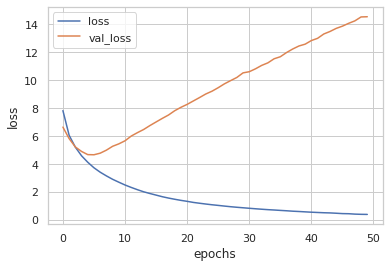

In [0]:
for label in ["loss","val_loss"]:
    plt.plot(train_model.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

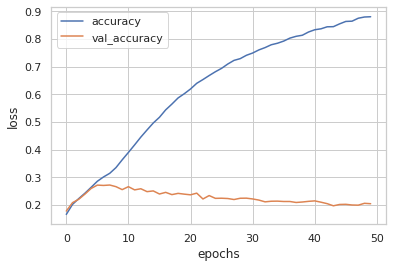

In [0]:
for label in ["accuracy","val_accuracy"]:
    plt.plot(train_model.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
len_m=range(30)
index_word = dict([(idx,line) for line, idx in token_keyword.word_index.items()])

In [0]:
def generating_description(img):
    inside = 'start'
    for ix in len_m:
        seq= token_keyword.texts_to_sequences([inside])[0]
        seq = pad_sequences([seq],30)
        nt = model.predict([img,seq],verbose=0)
        nt = np.argmax(nt)
        n_word = index_word[nt]
        inside += " " + n_word
        if n_word == "end":
            break
    return(inside)

## **Prediction on Test dataset**

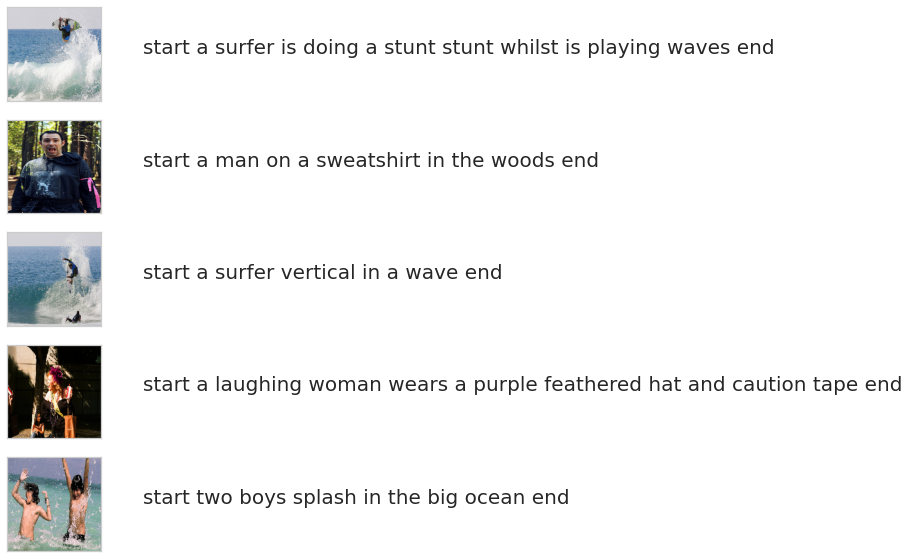

In [0]:
ctr = 1
fig = plt.figure(figsize=(5,10))
for jpg_id, img_f in zip(img_id_tr[100:105],dimg_te[100:105]):
    ## images 
    image_id = list_flickr_img + '/' + jpg_id
    image_load = load_img(image_id, target_size=(224,224,3))
    ax = fig.add_subplot(5,2,ctr,xticks=[],yticks=[])
    ax.imshow(image_load)
    ctr += 1

    ## captions
    description = generating_description(img_f.reshape(1,len(img_f)))
    ax = fig.add_subplot(5,2,ctr)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,description,fontsize=20)
    ctr += 1

plt.show()

In [0]:
idx_txt = dict([(idx,txt) for txt, idx in token_keytxt.txt_idx.items()])
num = 2
good_caps = []
bad_caps= [] 
score = [] 
ctr = 0 

## BLEU Score Analysis

In [0]:
for img_id, jpg_f, tk in zip(img_id_te,dimg_te,df_te):
    ctr += 1
    if ctr % 200 == 0:
        print("  {:4.2f}% is done..".format(100*ctr/float(len(img_id_te))))
    
    cap_true = [ idx_txt[i] for i in tk ]     
    cap_true = cap_true[1:-1] ## remove startreg, and endreg
    ## caps
    cap = generating_description(jpg_f.reshape(1,len(jpg_f)))
    cap = cap.split()
    cap = cap[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([cap_true],cap)
    score.append(bleu)
    if bleu > 0.7 and len(good_caps) < num:
        good_caps.append((bleu,img_id,cap_true,cap))
    elif bleu < 0.3 and len(bad_caps) < num:
        bad_caps.append((bleu,img_id,cap_true,cap))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  25.00% is done..
  50.00% is done..
  75.00% is done..
  100.00% is done..


In [0]:
print("Mean BLEU {:4.3f}".format(np.mean(score)))

Mean BLEU 0.611


Bad Caption


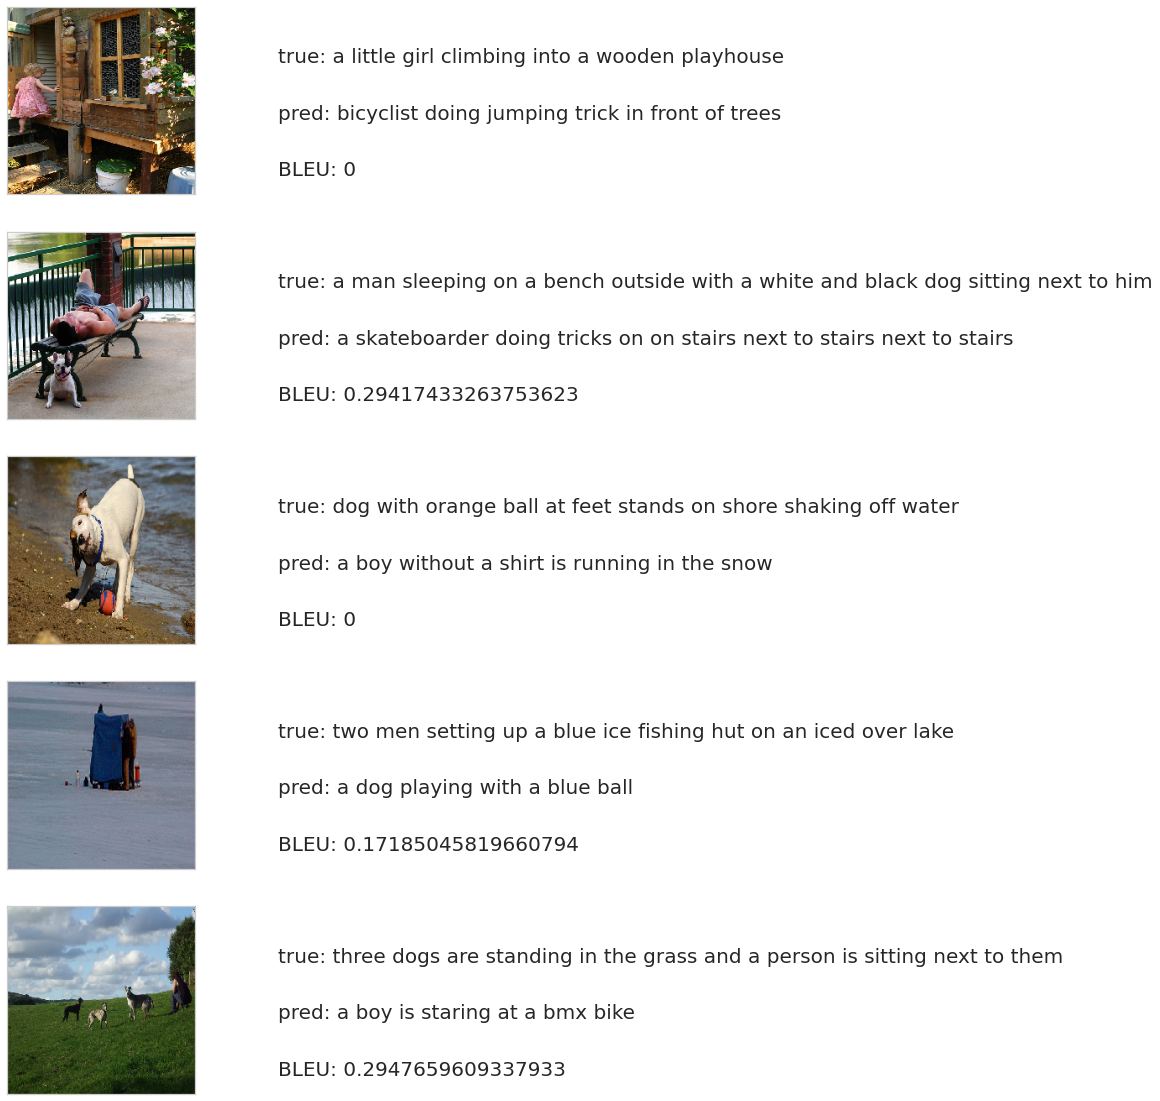

Good Caption


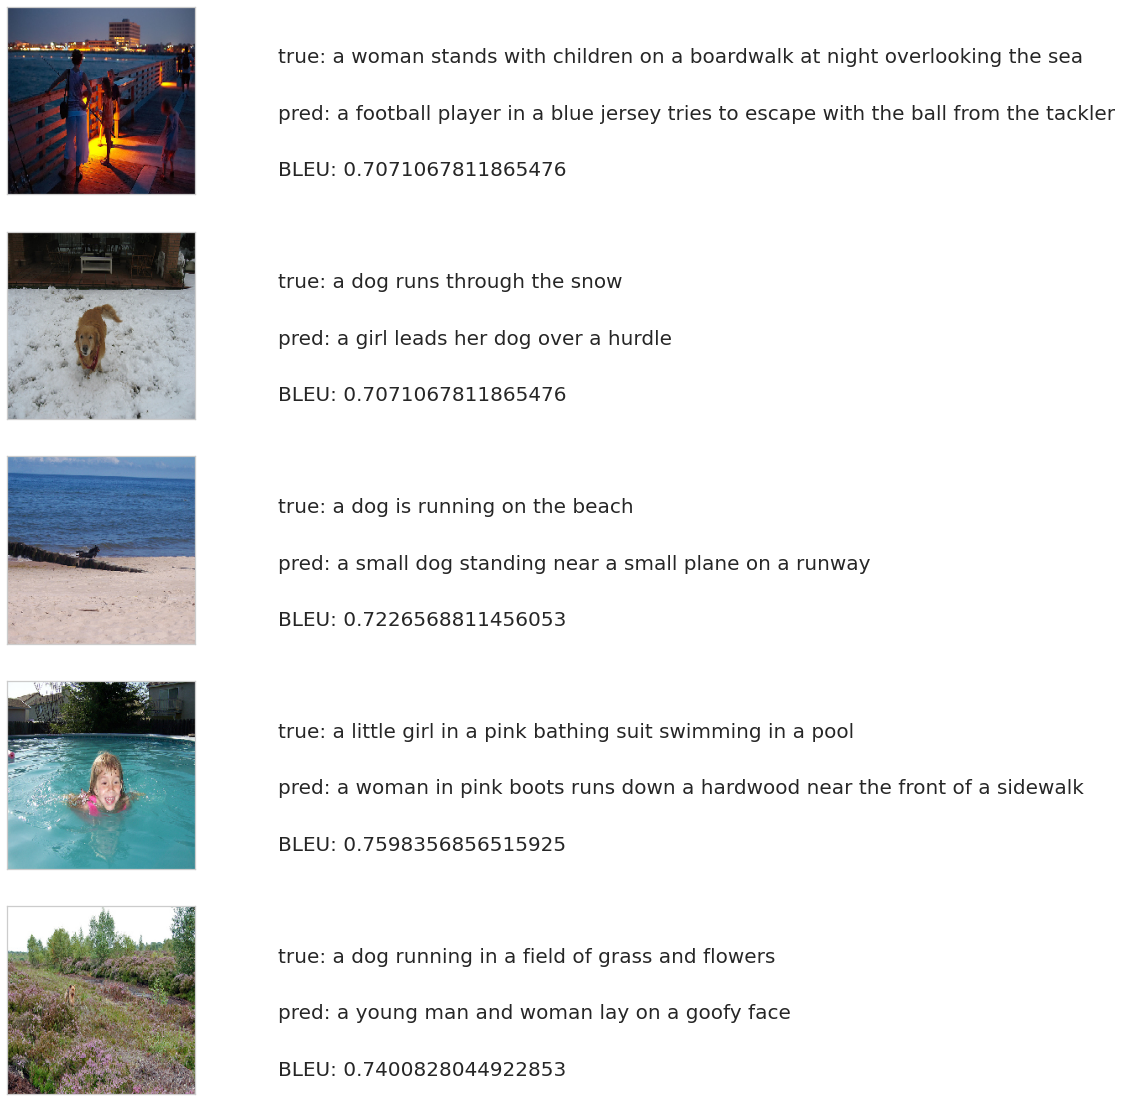

In [0]:
def bad_good_captions(bad_captions):
    def create_str(existing):
        true_value = ""
        for ix in existing:
            true_value += " " + ix
        return(true_value)
    ctr = 1
    fig = plt.figure(figsize=(10,20))
    len_c= len(bad_captions)
    for pb in bad_captions:
        bleu,img_id,existing,caption = pb
        ## images 
        filename = list_flickr_img + '/' + img_id
        image_load = load_img(filename, target_size=(224,224,3))
        ax = fig.add_subplot(len_c,2,ctr,xticks=[],yticks=[])
        ax.imshow(image_load)
        ctr += 1

        existing = create_str(existing)
        caption = create_str(caption)
        
        ax = fig.add_subplot(len_c,2,ctr)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"existing:" + existing,fontsize=20)
        ax.text(0,0.4,"predicted:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        ctr += 1
    plt.show()

print("Bad Caption")
bad_good_captions(bad_captions)
print("Good Caption")
bad_good_captions(good_captions)